# Module 1: Using CNN for dogs vs cats

To illustrate the Deep Learning pipeline, we are going to use a pretrained model to enter the [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) competition at Kaggle.

There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): *"**State of the art**: The current literature suggests machine classifiers can score above 80% accuracy on this task"*. So if you can beat 80%, then you will be at the cutting edge as of 2013!

##  Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
%matplotlib inline

Here you see that the latest version of PyTorch is installed by default.

In [2]:
torch.__version__

'1.7.0'

In [3]:
import sys
sys.version

'3.6.12 |Anaconda, Inc.| (default, Sep  9 2020, 00:29:25) [MSC v.1916 64 bit (AMD64)]'

Check if GPU is available and if not change the [runtime](https://jovianlin.io/pytorch-with-gpu-in-google-colab/).

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## Downloading the data

You can download the full dataset from Kaggle directly.

Alternatively, Jeremy Howard (fast.ai) provides a direct link to the catvsdogs [dataset](http://files.fast.ai/data/examples/). He's separated the cats and dogs into separate folders and created a validation folder as well.

For test purpose (or if you run on cpu), you should use the (small) sample directory.

In [5]:
#%mkdir ./data
# the following line should be modified if you run the notebook on your computer
# change directory to data where you will store the dataset
%cd ../content/data
#!wget http://files.fast.ai/data/examples/dogscats.tgz

C:\code\AI\notebooks-master\content\data


In [6]:
#!tar -zxvf dogscats.tgz

In [7]:
%ls

 驱动器 C 中的卷没有标签。
 卷的序列号是 D4CC-89F8

 C:\code\AI\notebooks-master\content\data 的目录

2020/12/04  19:47    <DIR>          .
2020/12/04  19:47    <DIR>          ..
2018/10/02  04:22    <DIR>          dogscats
2020/12/04  19:41       839,285,364 dogscats.tgz
               1 个文件    839,285,364 字节
               3 个目录 307,798,958,080 可用字节


In [8]:
%cd dogscats/
%ls

C:\code\AI\notebooks-master\content\data\dogscats
 驱动器 C 中的卷没有标签。
 卷的序列号是 D4CC-89F8

 C:\code\AI\notebooks-master\content\data\dogscats 的目录

2018/10/02  04:22    <DIR>          .
2018/10/02  04:22    <DIR>          ..
2018/10/02  04:21    <DIR>          sample
2020/12/04  19:52    <DIR>          test1
2018/10/02  04:22    <DIR>          train
2016/10/08  12:53    <DIR>          valid
               0 个文件              0 字节
               6 个目录 307,798,937,600 可用字节


The structure of the sub-folders inside the folder `dogscats` will be important for what follows:
```bash
.
├── test1 # contains 12500 images of cats and dogs
├── train
|   └── cats # contains 11500 images of cats
|   └── dogs # contains 11500 images of dogs
├── valid
|   └── cats # contains 1000 images of cats
|   └── dogs # contains 1000 images of dogs
├── sample
|   └── train
|       └── cats # contains 8 images of cats
|       └── dogs # contains 8 images of dogs    
|   └── valid 
|       └── cats # contains 4 images of cats
|       └── dogs # contains 4 images of dogs    
├── models # empty folder
```

You see that the 12 500 images of the test are in the `test1` sub-folder; the dataset of 25 000 labelled images has been split into a train set and a validation set.

The sub-folder `sample` is here only to make sure the code is running properly on a very small dataset.

## Data processing

In [9]:
%cd ..

C:\code\AI\notebooks-master\content\data


Below, we give the path where the data is stored. If you are running this code on your computer, you should modifiy this cell.

In [10]:
data_dir = 'dogscats'

```datasets``` is a class of the ```torchvision``` package (see [torchvision.datasets](http://pytorch.org/docs/master/torchvision/datasets.html)) and deals with data loading. It integrates a multi-threaded loader that fetches images from the disk, groups them in mini-batches and serves them continously to the GPU right after each _forward_/_backward_ pass through the network.

Images needs a bit of preparation before passing them throught the network. They need to have all the same size $224\times 224 \times 3$ plus some extra formatting done below by the normalize transform (explained later).

In [11]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

imagenet_format = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])

In [12]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), imagenet_format)
         for x in ['train', 'valid']}

In [13]:
os.path.join(data_dir,'train')

'dogscats\\train'

Interactive help on jupyter notebook thanks to `?`

In [14]:
?datasets.ImageFolder

We see that `datasets.ImageFolder` has attributes: classes, class_to_idx, imgs.

Let see what they are?

In [15]:
dsets['train'].classes

['cats', 'dogs']

The name of the classes are directly inferred from the structure of the folder:
```bash
├── train
|   └── cats
|   └── dogs
```

In [16]:
dsets['train'].class_to_idx

{'cats': 0, 'dogs': 1}

The label 0 will correspond to cats and 1 to dogs.

Below, you see that the first 5 imgs are pairs (location_of_the_image, label): 

In [17]:
dsets['train'].imgs[:5]

[('dogscats\\train\\cats\\cat.0.jpg', 0),
 ('dogscats\\train\\cats\\cat.1.jpg', 0),
 ('dogscats\\train\\cats\\cat.10.jpg', 0),
 ('dogscats\\train\\cats\\cat.100.jpg', 0),
 ('dogscats\\train\\cats\\cat.1000.jpg', 0)]

In [18]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'valid']}
dset_sizes

{'train': 23000, 'valid': 2000}

As expected we have 23 000 images in the training set and 2 000 in the validation set.

Below, we store the classes in the variable `dset_classes`:

In [19]:
dset_classes = dsets['train'].classes

The ```torchvision``` packages allows complex pre-processing/transforms of the input data (_e.g._ normalization, cropping, flipping, jittering). A sequence of transforms can be grouped in a pipeline with the help of the ```torchvision.transforms.Compose``` function, see [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html)

The magic help `?` allows you to retrieve function you defined and forgot!

In [20]:
?imagenet_format

Where is this normalization coming from?

As explained in the [PyTorch doc](https://pytorch.org/docs/stable/torchvision/models.html), you will use a pretrained model. All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.

In [21]:
loader_train = torch.utils.data.DataLoader(dsets['train'], batch_size=64, shuffle=True, num_workers=6)

In [22]:
?torch.utils.data.DataLoader

In [23]:
loader_valid = torch.utils.data.DataLoader(dsets['valid'], batch_size=5, shuffle=False, num_workers=6)

Try to understand what the following cell is doing?

In [24]:
count = 1
for data in loader_valid:
    print(count, end=',')
    if count == 1:
        inputs_try,labels_try = data
    count +=1

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,

In [25]:
labels_try

tensor([0, 0, 0, 0, 0])

In [26]:
inputs_try.shape

torch.Size([5, 3, 224, 224])

Got it: the validation dataset contains 2 000 images, hence this is 400 batches of size 5. `labels_try` contains the labels of the first batch and `inputs_try` the images of the first batch.

What is an image for your computer?

In [27]:
inputs_try[0]

tensor([[[ 1.1529,  1.1015,  1.0502,  ..., -1.4672, -1.4500, -1.4329],
         [ 1.0673,  1.0159,  0.9817,  ..., -1.4329, -1.4158, -1.3987],
         [ 0.9474,  0.9132,  0.8961,  ..., -1.4329, -1.4329, -1.4329],
         ...,
         [-1.6042, -1.5870, -1.5699,  ...,  0.8447,  0.7933,  0.7248],
         [-1.5528, -1.5528, -1.5699,  ...,  0.9303,  0.8961,  0.8789],
         [-1.5185, -1.5357, -1.5357,  ...,  0.9132,  0.8618,  0.8447]],

        [[ 0.8179,  0.7654,  0.7129,  ...,  0.8880,  0.9055,  0.9230],
         [ 0.6779,  0.6254,  0.5903,  ...,  0.9230,  0.9405,  0.9580],
         [ 0.5553,  0.5203,  0.5028,  ...,  0.9230,  0.9230,  0.9230],
         ...,
         [ 0.8529,  0.8704,  0.8880,  ...,  0.3978,  0.3452,  0.2752],
         [ 0.9580,  0.9055,  0.8880,  ...,  0.5203,  0.4853,  0.4503],
         [ 0.9930,  0.9755,  0.9230,  ...,  0.5203,  0.4678,  0.4503]],

        [[ 0.1999,  0.1651,  0.1128,  ...,  0.1128,  0.1302,  0.1476],
         [ 0.0779,  0.0431,  0.0082,  ...,  0

A 3-channel RGB image is of shape (3 x H x W). Note that entries can be negative because of the normalization.

A small function to display images:

In [28]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

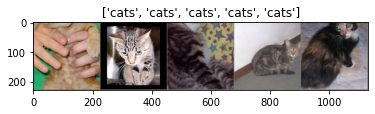

In [29]:
# Make a grid from batch from the validation data
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

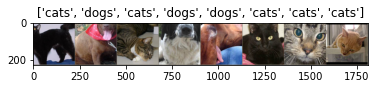

In [30]:
# Get a batch of training data
inputs, classes = next(iter(loader_train))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

## Creating VGG Model

The torchvision module comes with a zoo of popular CNN architectures which are already trained on [ImageNet](http://www.image-net.org/) (1.2M training images). When called the first time, if ```pretrained=True``` the model is fetched over the internet and downloaded to ```~/.torch/models```.
For next calls, the model will be directly read from there.

In [31]:
model_vgg = models.vgg16(pretrained=True)

We will first use VGG Model without any modification. In order to interpret the results, we need to import the 1000 ImageNet categories, available at: [https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json](https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json)

In [33]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2020-12-04 21:49:08--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.250.30
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.250.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: 'imagenet_class_index.json'

     0K .......... .......... .......... ....                 100% 20.0K=1.7s

2020-12-04 21:49:11 (20.0 KB/s) - 'imagenet_class_index.json' saved [35363/35363]



In [36]:
import json

fpath = 'C:/code/AI/notebooks-master/content/data/imagenet_class_index.json'

with open(fpath) as f:
    class_dict = json.load(f)
dic_imagenet = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [37]:
dic_imagenet[:4]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark']

In [38]:
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)

model_vgg = model_vgg.to(device)

In [39]:
outputs_try = model_vgg(inputs_try)

In [40]:
outputs_try

tensor([[ 0.8856, -0.6799,  0.7552,  ...,  4.9703,  3.4213,  0.8153],
        [-4.0279,  2.2066, -2.4929,  ..., -5.5610,  9.6409,  4.0004],
        [-2.9273, -2.8887, -3.0220,  ..., -3.3633,  2.1048,  4.3943],
        [-4.7953, -0.6366,  1.9153,  ..., -5.5957, -0.1942,  5.2399],
        [-3.8134, -2.2582, -3.8261,  ..., -5.1984,  1.7426,  4.3922]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [41]:
outputs_try.shape

torch.Size([5, 1000])

To translate the outputs of the network into 'probabilities', we pass it through a [Softmax function](https://en.wikipedia.org/wiki/Softmax_function)

In [42]:
m_softm = nn.Softmax(dim=1)
probs = m_softm(outputs_try)
vals_try,preds_try = torch.max(probs,dim=1)

Let check, that we obtain a probability!

In [43]:
torch.sum(probs,1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<SumBackward1>)

In [44]:
vals_try

tensor([0.6123, 0.6850, 0.4045, 0.8415, 0.5096], device='cuda:0',
       grad_fn=<MaxBackward0>)

In [45]:
print([dic_imagenet[i] for i in preds_try.data])

['hamster', 'tabby', 'tabby', 'tabby', 'black-footed_ferret']


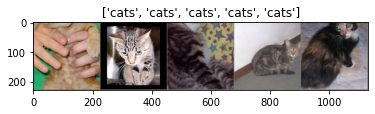

In [46]:
out = torchvision.utils.make_grid(inputs_try.data.cpu())

imshow(out, title=[dset_classes[x] for x in labels_try.data.cpu()])

### Modifying the last layer and setting the gradient false to all layers

In [47]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

![vgg16](https://dataflowr.github.io/notebooks/Module1/img/vgg16.png)

In this practical example, our goal is to use the already trained model and just change the number of output classes. To this end we replace the last ```nn.Linear``` layer trained for 1000 classes to ones with 2 classes. In order to freeze the weights of the other layers during training, we set the field ```required_grad=False```. In this manner no gradient will be computed for them during backprop and hence no update in the weights. Only the weights for the 2 class layer will be updated.

In [48]:
for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier._modules['6'] = nn.Linear(4096, 2)
model_vgg.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

PyTorch documentation for [LogSoftmax](https://pytorch.org/docs/stable/nn.html#logsoftmax)

In [49]:
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
  (7): LogSoftmax(dim=1)
)


We load the model on GPU.

In [50]:
model_vgg = model_vgg.to(device)

## Training the fully connected module

### Creating loss function and optimizer

PyTorch documentation for [NLLLoss](https://pytorch.org/docs/stable/nn.html#nllloss) and the [torch.optim module](https://pytorch.org/docs/stable/optim.html#module-torch.optim)

In [51]:
criterion = nn.NLLLoss()
lr = 0.001
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)

### Training the model

In [52]:
def train_model(model,dataloader,size,epochs=1,optimizer=None):
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in dataloader:
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            loss = criterion(outputs,classes)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

In [53]:
%%time
train_model(model_vgg,loader_train,size=dset_sizes['train'],epochs=2,optimizer=optimizer_vgg)

Loss: 0.0023 Acc: 0.9557
Loss: 0.0013 Acc: 0.9704
Wall time: 3min 13s


In [ ]:


def test_model(model,dataloader,size):
    model.eval()
    predictions = np.zeros(size)
    all_classes = np.zeros(size)
    all_proba = np.zeros((size,2))
    i = 0
    running_loss = 0.0
    running_corrects = 0
    for inputs,classes in dataloader:
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        loss = criterion(outputs,classes)           
        _,preds = torch.max(outputs.data,1)
            # statistics
        running_loss += loss.data.item()
        running_corrects += torch.sum(preds == classes.data)
        predictions[i:i+len(classes)] = preds.to('cpu').numpy()
        all_classes[i:i+len(classes)] = classes.to('cpu').numpy()
        all_proba[i:i+len(classes),:] = outputs.data.to('cpu').numpy()
        i += len(classes)
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.data.item() / size
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
    return predictions, all_proba, all_classes

In [ ]:
predictions, all_proba, all_classes = test_model(model_vgg,loader_valid,size=dset_sizes['valid'])

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(loader_valid))

out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

In [ ]:
outputs = model_vgg(inputs[:n_images].to(device))
print(torch.exp(outputs))

In [ ]:
classes[:n_images]

## Speeding up the learning by precomputing features

Here you are wasting a lot of time computing over and over the same quantities. Indeed, the first part of the VGG model (called `features` and made of convolutional layers) is frozen and never updated. Hence, we can precompute for each image in the dataset, the output of these convolutional layers as these outputs will always be the same during your training process.

This is what is done below.

In [ ]:
x_try = model_vgg.features(inputs_try)

In [ ]:
x_try.shape

You see that the features computed for an image is of shape 512x7x7 (above we have a batch corresponding to 5 images).

In [ ]:
def preconvfeat(dataloader):
    conv_features = []
    labels_list = []
    for data in dataloader:
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [ ]:
%%time
conv_feat_train,labels_train = preconvfeat(loader_train)

In [ ]:
conv_feat_train.shape

In [ ]:
%%time
conv_feat_valid,labels_valid = preconvfeat(loader_valid)

### Creating a new data generator

We will not load images anymore, so we need to build our own data loader. If you do not understand the cell below, it is OK! We will come back to it in Lesson 5...

In [ ]:
dtype=torch.float
datasetfeat_train = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_train,labels_train)]
datasetfeat_train = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_train]
loaderfeat_train = torch.utils.data.DataLoader(datasetfeat_train, batch_size=128, shuffle=True)

In [ ]:
%%time
train_model(model_vgg.classifier,dataloader=loaderfeat_train,size=dset_sizes['train'],epochs=50,optimizer=optimizer_vgg)

In [ ]:
datasetfeat_valid = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_valid,labels_valid)]
datasetfeat_valid = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_valid]
loaderfeat_valid = torch.utils.data.DataLoader(datasetfeat_valid, batch_size=128, shuffle=False)

In [ ]:
predictions, all_proba, all_classes = test_model(model_vgg.classifier,dataloader=loaderfeat_valid,size=dset_sizes['valid'])

## 4. Viewing model prediction (qualitative analysis)

The most important metrics for us to look at are for the validation set, since we want to check for over-fitting.

With our first model we should try to overfit before we start worrying about how to handle that - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques after the 2 weeks break...)


As well as looking at the overall metrics, it's also a good idea to look at examples of each of:

   1. A few correct labels at random
   2. A few incorrect labels at random
   3. The most correct labels of each class (ie those with highest probability that are correct)
   4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
   5. The most uncertain labels (ie those with probability closest to 0.5).

In general, these are particularly useful for debugging problems in the model. Since our model is very simple, there may not be too much to learn at this stage...

In [ ]:
# Number of images to view for each visualization task
n_view = 8

In [ ]:
correct = np.where(predictions==all_classes)[0]

In [ ]:
len(correct)/dset_sizes['valid']

In [ ]:
from numpy.random import random, permutation
idx = permutation(correct)[:n_view]

In [ ]:
idx

In [ ]:
loader_correct = torch.utils.data.DataLoader([dsets['valid'][x] for x in idx],batch_size = n_view,shuffle=True)

In [ ]:
for data in loader_correct:
    inputs_cor,labels_cor = data

In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_cor)

imshow(out, title=[l.item() for l in labels_cor])

In [ ]:
from IPython.display import Image, display
for x in idx:
    display(Image(filename=dsets['valid'].imgs[x][0], retina=True))

In [ ]:
incorrect = np.where(predictions!=all_classes)[0]
for x in permutation(incorrect)[:n_view]:
    #print(dsets['valid'].imgs[x][1])
    display(Image(filename=dsets['valid'].imgs[x][0], retina=True))

In [ ]:
#3. The images we most confident were cats, and are actually cats
correct_cats = np.where((predictions==0) & (predictions==all_classes))[0]
most_correct_cats = np.argsort(all_proba[correct_cats,1])[:n_view]

In [ ]:
for x in most_correct_cats:
    display(Image(filename=dsets['valid'].imgs[correct_cats[x]][0], retina=True))

In [ ]:
#3. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((predictions==1) & (predictions==all_classes))[0]
most_correct_dogs = np.argsort(all_proba[correct_dogs,0])[:n_view]

In [ ]:
for x in most_correct_dogs:
    display(Image(filename=dsets['valid'].imgs[correct_dogs[x]][0], retina=True))

# Conclusion

What did we do in the end? A simple logistic regression! If the connection is unclear, we'll explain it on a much simpler example in the next course. 

We probably killed a fly with a sledge hammer!

In our case, the sledge hammer is VGG pretrained on Imagenet, a dataset containing a lot of pictures of cats and dogs. Indeed, we saw that without modification the network was able to predict dog and cat breeds. Hence it is not very surprising that the features computed by VGG are very accurate for our classification task. In the end, we need to learn only the parameters of the last linear layer, i.e. 8194 parameters (do not forget the bias $2\times 4096+2$). Indeed, this can be done on CPU without any problem.

Nevertheless, this example is still instructive as it shows all the necessary steps in a deep learning project. Here we did not struggle with the learning process of a deep network, but we did all the preliminary engineering tasks: dowloading a dataset, setting up the environment to use a GPU, preparing the data, computing the features with a pretrained VGG, saving them on your drive so that you can use them for a later experiment... These steps are essential in any deep learning project and a necessary requirement before having fun playing with network architectures and understanding the learning process.